<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import lightgbm as lgb

## Подготовка

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
print(data.head())

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32


In [4]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Выводы**

- Данные содержат информацию о заказах такси с марта 2018 года по август 2018 года.
- Таблица содержит 1 стоблец и 26496 строк
- Данные полные, пропусков нет.

**Ресемплирование по одному часу**

In [6]:
data = data.resample('1H').sum()

После ресемплирования данные агрегированы по часу

## Анализ

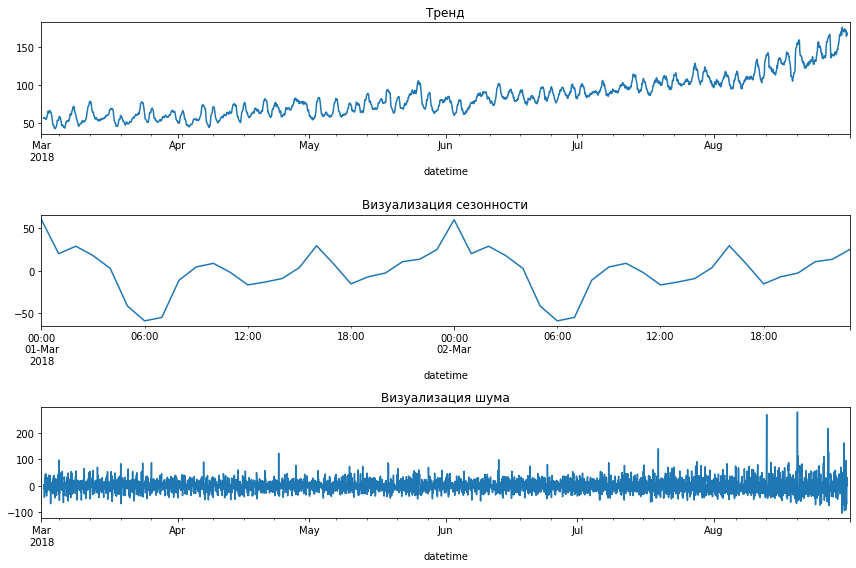

In [7]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(12, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca())
plt.title('Визуализация сезонности')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Визуализация шума')

plt.tight_layout()

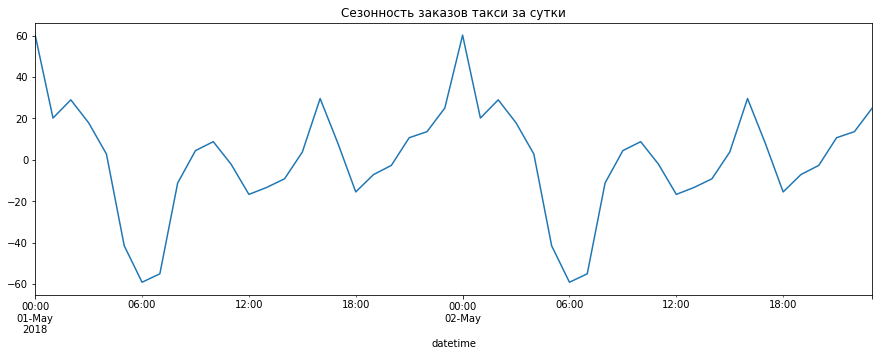

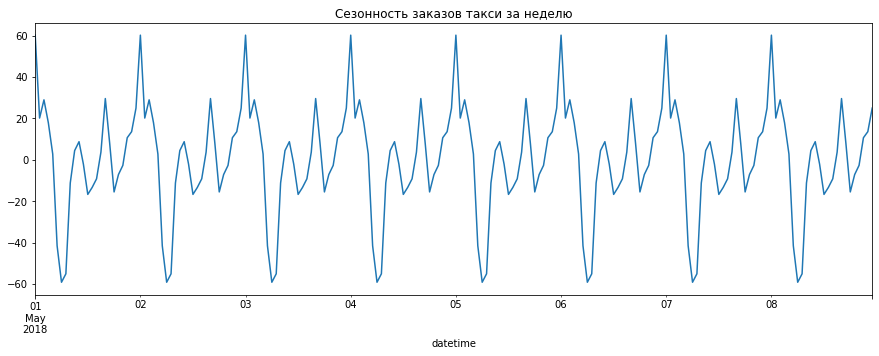

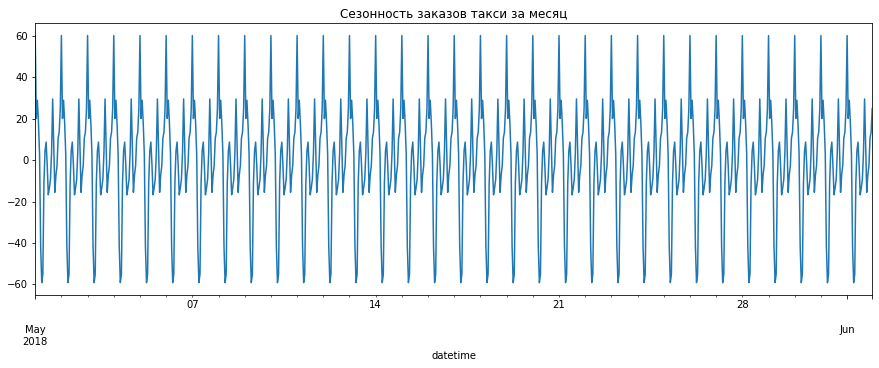

In [8]:
#за сутки
decomposed.seasonal['2018-05-01':'2018-05-02'].plot(figsize=(15,5))
plt.title('Сезонность заказов такси за сутки')
plt.show()

#неделя
decomposed.seasonal['2018-05-01':'2018-05-08'].plot(figsize=(15,5))
plt.title('Сезонность заказов такси за неделю')
plt.show()

#месяц
decomposed.seasonal['2018-05-01':'2018-06-01'].plot(figsize=(15,5))
plt.title('Сезонность заказов такси за месяц')
plt.show()

**Выводы**
1. Тренд заказов такси растет, это указывает на увеличение популярности услуги такси
2. Сезонность заказов такси за сутки:
 - Пик приходится на полночь, думаю связано с тем, что, это единственный способ передвижения на общественном транспорте =) 
 - Начиная с 00:00 и до 06:00, спрос на такси снижается, что, вероятно, связано с ночными часами.
 - С 06:00 до 12:00 спрос растет, достигая пика ближе к полудню. Это может быть связано с людьми, которые едут на работу или другие утренние дела
 - После обеда наблюдается второй пик, который может быть связан с окончанием рабочего дня и возвращением домой =)

**Подготовка данных**

Создание признаков

In [9]:
def make_features_optimized(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['rolling_std'] = data['num_orders'].shift().rolling(rolling_mean_size).std()

make_features_optimized(data, 168, 2)

Выбор 168 часов равно 7 дням. Таким образом, учитывая временной ряд с часовой дискретизацией, выбор лага в 168 позволяет модели учитывать недельную сезонность данных

**Разделение данных**

In [10]:
features = data.drop('num_orders', axis=1)
target = data['num_orders']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, shuffle=False
)

features_train = features_train.dropna()
target_train = target_train[features_train.index]

features_test = features_test.dropna()
target_test = target_test[features_test.index]

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

## Обучение

**Линейная регрессия**

In [11]:
%%time
lr_params = {
    'fit_intercept': [True, False],
    'normalize': [True, False]
}

lr_grid = GridSearchCV(LinearRegression(), lr_params, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
lr_grid.fit(features_train, target_train)

lr_rmse = -lr_grid.best_score_
print('Линейная регрессия RMSE:', lr_rmse)

Линейная регрессия RMSE: 22.603116399252077
CPU times: user 3.76 s, sys: 4.71 s, total: 8.47 s
Wall time: 8.46 s


**CatBoostRegressor**

In [12]:
%%time
cb_params = {
    'iterations': [500],
    'depth': [5, 8],
    'learning_rate': [0.01, 0.1],
    'loss_function': ['RMSE']
}

cb_grid = GridSearchCV(CatBoostRegressor(verbose=0, random_state=42), cb_params, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
cb_grid.fit(features_train, target_train)

cb_rmse = -cb_grid.best_score_
print('CatBoost RMSE:', cb_rmse)

CatBoost RMSE: 22.744097862186685
CPU times: user 9min 57s, sys: 3.18 s, total: 10min
Wall time: 10min 20s


**Оценка лучшей модели на тестовой выборке**

In [13]:
results = {
    'LinearRegression': lr_rmse,
    'CatBoost': cb_rmse,
}

results_df = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE'])
results_df = results_df.sort_values(by='RMSE')
print(results_df)

                       RMSE
LinearRegression  22.603116
CatBoost          22.744098


In [14]:
models = {
    'Линейная регрессия': lr_grid,
    'CatBoost': cb_grid,
}

best_model_name = min(models, key=lambda k: np.sqrt(-models[k].best_score_))
best_model = models[best_model_name].best_estimator_

print(f"Лучшая модель: {best_model_name}")

Лучшая модель: Линейная регрессия


## Тестирование

In [15]:
predictions = best_model.predict(features_test)
test_rmse = np.sqrt(mean_squared_error(target_test, predictions))
print(f"RMSE на тестовой выборке для {best_model_name}: {test_rmse}")

RMSE на тестовой выборке для Линейная регрессия: 34.46815409088631


**Итоговый вывод**

В рамках анализа были рассмотрены две модели: линейная регрессия и CatBoost. Целью было предсказать количество заказов такси на следующий час. Для улучшения качества предсказаний были созданы дополнительные признаки, такие как отставания и скользящие статистики.

С помощью метода кросс-валидации и поиска параметров GridSearchCV были найдены оптимальные гиперпараметры для каждой из моделей.
- LinearRegression  22.603116
- CatBoost          22.744098

RMSE на тестовой выборке для Линейная регрессия показала ~34, что соотвествует условиям заказчика.